# Unscented Kalman Filters 

In [30]:
# With this backend, the output of plotting commands is displayed 
# inline within frontends, directly below the code cell that produced it
%matplotlib inline

Nonlinearity can appear in two places: in measurements or in the process model. 
In measurements the nonlinearity is due to noises too difficult and unpredictable to be considered and accurately modeled - for example, with RSSI measurements, the reflection of the signal on the walls of a building, an object obstructing two sensors or even the placement of the antennas of the sensors may change the RSSI value. 
These noises are intrinsecally nonlinear. 
Another element of nonlinearity is the process model itself for a certain phenomena. 
If we are tracking a ball traveling through the air, the effects of air drag lead to non-linear behaviour. 

The Standard Kalman Filter performs poorly or not at all with these sorts of problems as it is thought for linear optimization. 

The Extended Kalman Filter, while considering non-linear models, linearizes them by producing a Jacobian Matrix at each iteration, which is computationally expensive. 

We will now study the use of Uscented Kalman Filters.

Let's first see an example of non-linear plot, to emphasize the effects of nonlinearity. 

The definition of a nonlinear function is a function that does not graph into a straight line and does not have a constant slope, of form

 $f(x) = ax + b$

So let's first plot an example of nonlinear function

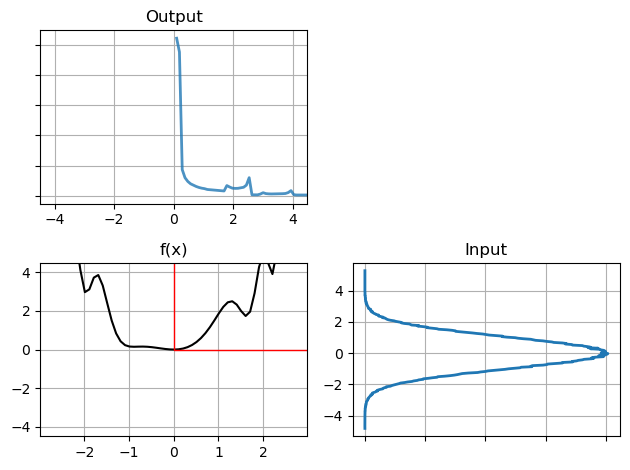

In [31]:
import matplotlib.pyplot as plt 
from numpy.random import normal, multivariate_normal
import numpy as np 
import scipy.stats 

# create 500000 samples with mean 0, std 1
gaussian = (0., 1.)
data = normal(loc = gaussian[0], scale= gaussian[1], size= 500000)

def nonlinear_function(x): 
    return x**2 + np.sin(x**3)

y_values = nonlinear_function(data)
x0 = np.mean(data)
in_std = np.std(data)

y = nonlinear_function(x0)
std = np.std(y_values)

in_lims = [x0 - in_std*3, x0 + in_std*3]
out_lims = [y - std*3, y + std*3]

# plotting output
h = np.histogram(y_values, 300, density = False)
plt.subplot(2, 2, 1)
plt.plot(h[1][1:], h[0], lw = 2, alpha=0.8)

plt.xlim(out_lims[0], out_lims[1])
plt.gca().yaxis.set_ticklabels([])
plt.grid(True)
plt.title('Output')

#plt.axvline(np.mean(y_values), ls='--', lw=2)
#plt.axline(nonlinear_function(x0), lw=1)

norm = scipy.stats.norm(y, in_std)

# plottinh the transfer function 
plt.subplot(2,2,3)
x = np.arange(in_lims[0], in_lims[1], 0.1)
y = nonlinear_function(x)

plt.plot(x, y, 'k')
isct = nonlinear_function(x0)
plt.plot([x0, x0, in_lims[1]], [out_lims[1], isct, isct], color='r', lw=1)
plt.xlim(in_lims)
plt.ylim(out_lims)
plt.grid(True)
plt.title('f(x)')

#plot input 
h = np.histogram(data, 300, density = True)

plt.subplot(2,2,4)
plt.plot(h[0], h[1][1:], lw=2)
plt.gca().xaxis.set_ticklabels([])
plt.title('Input')
plt.tight_layout()
plt.grid(True)
plt.show()



f(x) is the nonlinear transformation function chosen. 
The input follows a gaussian distribution with mean zero and the result
is computed by sampling 500000 points from the imput and builduing a 
histogram of the result. 
These points are called **sigma points**. 

From the computed output histogram we can compute a mean and 
a standard deviation which would give us an updated, approximated gaussian. 

Let's see a scatter plot of the points (data) before and after 
having passed the nonlinear function

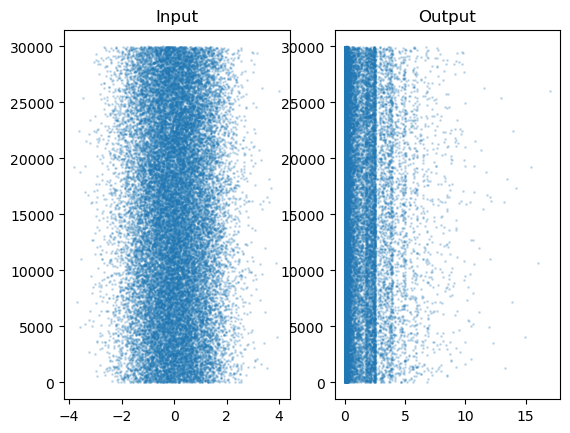

In [32]:
N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.2, s=1)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(nonlinear_function(data[:N]), range(N), alpha=.2, s = 1)

As we can see the input data follows a Gaussian, as it was so generated.
The noise scatters around a zero mean.
On the other hand, the data output from the nonlinear function has a 
defined structure. 

The sampling approach is called Monte Carlo approach and it is used by some Kalman Filter designs, such as the particle filter.
Sampling requires no specialized knowledge, and does not require a closed form solution. No matter how non-linear or poorly behaved the function is, as long as we sample with enough sigma points we will build an accurate output distribution. 

The problem rises with the concept of "enough points". The graph above was created with 500000 points and the output is still not smooth. What's worse, this is only considering 1 dimension. 
The number of points required increases by the power og the number of dimensions. 
So, while this method works, it is very computationally expensive. 

The Uscented Kalman Filter uses sigma points but drastically reduces the amount of computation by using a deterministic method to choose the relevant points. 

## Sigma Points - Sampling from a Distribution

Let's look at the problem in terms of a 2D covariance ellipse. 
Assuming some arbitrary nonlinear function, we will take random points from the first covariance ellipse, pass them through the nonlinear function, and plot their new position. 
Then we can compute mean and covariance of the transformed points, and use that as our estimate of the mean and probability distribution. 

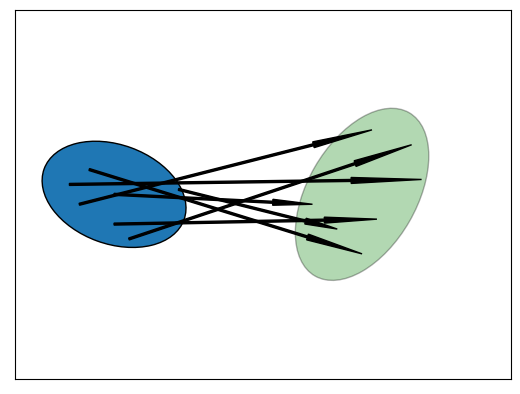

In [33]:
from matplotlib.patches import Ellipse, Arrow

def arrow(x1,y1,x2,y2, width=0.2):
    return Arrow(x1,y1, x2-x1, y2-y1, lw=1, width=width, ec='k', color='k')

plt.cla()
ax = plt.gca()

ax.add_artist(Ellipse(xy=(2,5), width=2, height=3,angle=70,linewidth=1,ec='k'))
ax.add_artist(Ellipse(xy=(7,5), width=2.2, alpha=0.3, height=3.8,angle=150,fc='g',linewidth=1,ec='k'))

ax.add_artist(arrow(2, 5, 6, 4.8))
ax.add_artist(arrow(1.5, 5.5, 7, 3.8))
ax.add_artist(arrow(2.3, 4.1, 8, 6))
ax.add_artist(arrow(3.3, 5.1, 6.5, 4.3))
ax.add_artist(arrow(1.3, 4.8, 7.2, 6.3))
ax.add_artist(arrow(1.1, 5.2, 8.2, 5.3))
ax.add_artist(arrow(2, 4.4, 7.3, 4.5))

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.axis('equal')
plt.xlim(0,10); plt.ylim(0,10)
plt.show()



On the left, ellipse with one sigma distribution for two state variables. 
The arrows show how many randomly sampled points might be transformed by some arbitraty nonlinear function to a new distribution.
The ellipse on the right indicates the estimate of mean and variance of the collected points. 

Lets write a function that passes 10000 sampled points randomly drawn from a Gaussian with mean and covariance: 

$ \mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}, 
\Sigma = \begin{bmatrix} 32 & 15 \\ 15 & 40 \end{bmatrix}
$


Through the nonlinear system: 

$$ 
\begin{cases} \overline{x} = y + x \\ \overline{y} = 0.1x^2 + y^2
\end{cases}



C:\Users\giuli\AppData\Local\Temp\ipykernel_14584\537691452.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
C:\Users\giuli\AppData\Local\Temp\ipykernel_14584\537691452.py:37: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


Difference in mean x=0.177, y=42.780


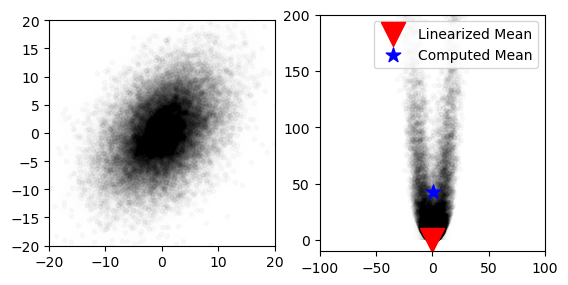

In [34]:
import numpy as np
from numpy.random import multivariate_normal

def plot_bivariate_colormap(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    xmin = xs.min()
    xmax = xs.max()
    ymin = ys.min()
    ymax = ys.max()
    values = np.vstack([xs, ys])
    kernel = scipy.stats.gaussian_kde(values)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    Z = np.reshape(kernel.evaluate(positions).T, X.shape)
    plt.gca().imshow(np.rot90(Z), cmap=plt.cm.Greys,
                     extent=[xmin, xmax, ymin, ymax])


def plot_monte_carlo_mean(xs, ys, f, mean_fx, label, plot_colormap=True):
    fxs, fys = f(xs, ys)

    computed_mean_x = np.average(fxs)
    computed_mean_y = np.average(fys)

    ax = plt.subplot(121)
    ax.grid(b=False)

    plot_bivariate_colormap(xs, ys)

    plt.scatter(xs, ys, marker='.', alpha=0.02, color='k')
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)

    ax = plt.subplot(122)
    ax.grid(b=False)

    plt.scatter(fxs, fys, marker='.', alpha=0.02, color='k')
    plt.scatter(mean_fx[0], mean_fx[1],
                marker='v', s=300, c='r', label=label)
    plt.scatter(computed_mean_x, computed_mean_y,
                marker='*',s=120, c='b', label='Computed Mean')

    plot_bivariate_colormap(fxs, fys)
    ax.set_xlim([-100, 100])
    ax.set_ylim([-10, 200])
    plt.legend(loc='best', scatterpoints=1)
    print ('Difference in mean x={:.3f}, y={:.3f}'.format(
           computed_mean_x-mean_fx[0], computed_mean_y-mean_fx[1]))
    

def f_nonlinear_xy(x, y): 
    return np.array([x + y, .1*x**2 + y*y])

mean = (0., 0.)
p = np.array([[32., 15.], [15., 40.]])
# compute linearized mean
mean_fx = f_nonlinear_xy(*mean)

#generate random points from it
xs, ys = multivariate_normal(mean=mean, cov=p, size = 10000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, mean_fx, 'Linearized Mean')

As can be seen by the plot, linearizing the function might result in a large error (Extended Kalman Filters adopt this technique)

Linearized mean is simply calculating the mean of the output from the mean of the input. 
Using Monte Carlo we sample points following the input distribution and based off their distribution in the output a new mean and 
standard deviation are calculated. 

## A Quick Example

Before delving into the math the Unscented Kalman Filter (UKF) uses to choose the sigma points to performe the computation, let's start with an example.

UKF can use many different algorithms to generate sigma points. Several are provided by FilterPy. 
Here a possibility:

In [35]:
%pip install filterpy 

Note: you may need to restart the kernel to use updated packages.


In [36]:
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=2, kappa=1)

This will be explained later, but the object will generate weighted sigma points for any given mean and covariance.

Let's look at this example, where the point's size indicate how much it is weighted:

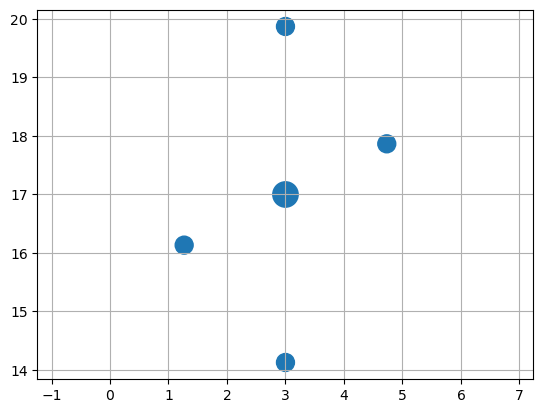

In [37]:
import numpy as np
import matplotlib.pyplot as plt 

def plot_sigmas(sigmas, x, cov):
    if not np.isscalar(cov):
        cov = np.atleast_2d(cov)
    pts = sigmas.sigma_points(x=x, P=cov)
    plt.scatter(pts[:, 0], pts[:, 1], s=sigmas.Wm*1000)
    plt.grid(True)
    plt.axis('equal')

plot_sigmas(sigmas, x=[3, 17], cov=[[1, .5], [.5, 3]])


There are here 5 points, centered around the mean (3,17), in a specific pattern. 
This is proven to do as well as generating 500000 points with MonteCarlo. 

The filter we will implement in this example is a standard 1D linear filter. Afterwards, nonlinear. 
The Kalman Filter uses the matrix **F** to compute the state transition function. 
Matrices mean linear algebra, which works for linear problems, not for nonlinear ones. 
So, instead of a matrix, we provide a function - just like the one above.
Kalman Filter class uses anothe matrix **H** to implement the measurement function, which converts a state into the equivalent measurement.
Also here, instead of a matrix we provide a function.

Implement easy **F** and **H**: 

In [38]:
# position and velocity for linear movement no acceleration 
def fx(x, dt): 
    xout = np.empty_like(x)
    xout[0] = x[1]*dt + x[0]
    xout[1] = x[1]
    return xout

def hx(x): 
    return x[:1] # returns position of x



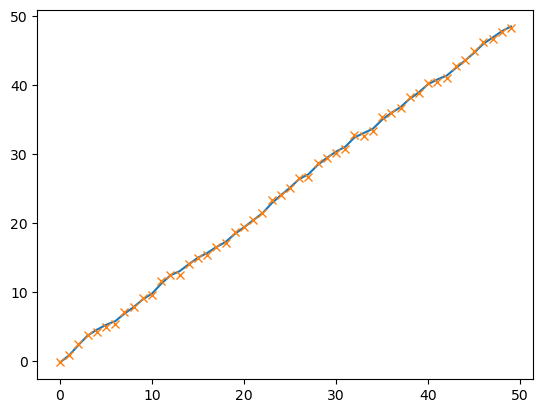

In [39]:
from numpy.random import randn 
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P *= 10
ukf.R *= .5
ukf.Q *= Q_discrete_white_noise(2, dt=1., var = 0.03)

zs, xs = [], []

for i in range(50): 
    z = i + randn()*.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)

plt.plot(xs)
plt.plot(zs, marker='x', ls='')


What this is doing is the following:
takes a point and generates its sigma points (here using JulierSigmaPoints).
Having then state transformation matrix input all points into it and then generates new mean given the outputs. 

## Unscented Transform

### Choosing Sigma Points

The lowest number that can be taken is 3 (this way, can calculate mean and variance) - for each dimension. 
We can pass these points through a nonlinear function f(x) and compute the resulting mean and variance. 
The mean can be computed as the average of the three points, but this is not very general. For example, for a very nonlinear problem we might want to weight the central point much higher than the outside points. 

A more general approach is then to use a weighted mean to calculate the new mean - and a weighted covariance for the variance. 
We consider different weights for calculating the mean and variance, with constraints such that the sum of the weights is 1 (normalized). Then, the new_mean is the weighted average of the sigma points and the new_covariance is given by the weighted difference between sigma point and mean (formulas in book).

### Unscented Transform

If we start by considering the UT without thinking about how calculating the sigma points, the algorithm simply passes the sigma points through a nonlinear function and then computed the mean and covariance of the transformed points. 
Than mean and covariance become the new estimate. 

### Accuracy of the UT
To see how powerful the UT is, let's see an example comparing the accuracy of the Computed Mean from 50000 sampled points and the one from the Kalman filters with 5 sigma points: 

C:\Users\giuli\AppData\Local\Temp\ipykernel_14584\537691452.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
C:\Users\giuli\AppData\Local\Temp\ipykernel_14584\537691452.py:37: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


Difference in mean x=-0.097, y=0.549


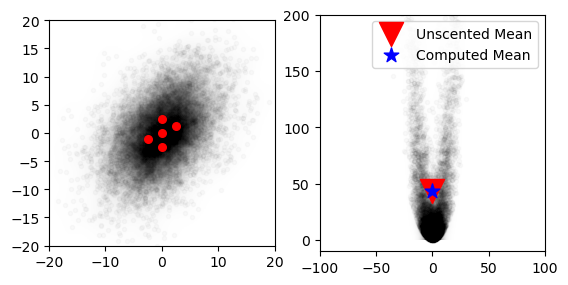

In [40]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats

#initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15.],[15., 40.]])

#create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

# pass through a nonlinear function
sigmas_f = np.empty((5,2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i,0], sigmas[i,1])

# use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

# generate random points
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30)
    

## UKF

### Prediction Step
Compute the prior using the nonlinear process model and passing through it the selected sigma points. 
Applying an Uscented Transform to the obtained points will then allow us to calculate the new mean and covariance

### Update Step
From the measurement vector according to a measurement function select a set of sigma points y. 
Compute similarly mean and covariance using an Uscented Transform. 
Then, compute residual and kalman gain by comparing the predicted mean and covariance with the measured one. 

## Var Der Merwe's Scaled Sigma Points Algorithm

There are many algorithms to select sigma points. The one presented is the most widely affirmed and used, and it is 
a variation of the Julier Sigma Points seen before. 
Uses three parameters to control how the sigma points are distributed and weighted ($\alpha, \beta, \kappa$)
(larger the $\alpha$ the more the points spread out)

### Sigma Points Computation
Basically scaling the covariance matrix by a constant (row by row), taking the square root of it and ensure simmetry by adding or subtracting it 
from the mean. 
Will talk more in detail later. 

### Weight Computation
The weights for the mean and covariance cannot be proven to be optimal for all nonlinear problem.
But, reasoning about how they are calculated, the square root of the variance is the standard deviation so 
the sigma points are spread out roughly according to 1 $\sigma$. 

### Parameter Choice
$\beta$ = 2 is reasonable for a Gaussian \
$\kappa$ = 3 - n, where n is the number of dimensions of **x** \
0 $\le \alpha \le$ 1 


## Example - Track a 2D object using UKF
Filter to track an object in 2D with constant velocity model. 
Matrices to develop are: x, F, H, R, Q


In [44]:
# state transition function: here (linear, just as example), we have the 
# constant velocity function to represent the motion of x,y coordinates.

def state_transition_f(x, dt): 
    """ state transition function for a constant velocity object"""

    F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0], 
                 [0, 0, 1, dt], 
                 [0, 0, 0, 1]])
    return F @ x

# measurement function - basically reduces the state matrix to the point 
# of view of sensors (e.g. from a state matrix about velocity and position
# to measurements that only calculate position)

def measurement_f(x): 
    return x[[0, 2]]

Now, having computed the functions - sigma points and weights. 
Seen Van Der Merwe's version, FilterPy uses a class named SigmaPOints which must implement a method sigma_points(self, x, P)
and contain attributes Wm and Wc holding the weights for mean and covariance. 

From the SigmaPoint class there is derived MerweScaledSigmaPoints, specifying when using it $\alpha, \beta, \kappa$

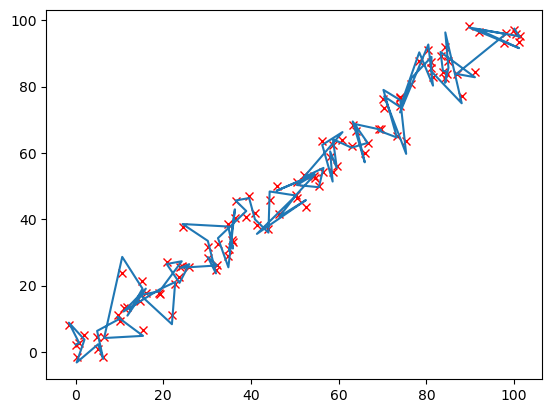

In [111]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
import numpy as np
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

std_x, std_y = 5, 5
dt = 3.0
# sigma points
sigmas = MerweScaledSigmaPoints(4, alpha=.8, beta=2., kappa=6.)
ukf = UKF(dim_x=4, dim_z=2, dt=dt, fx=state_transition_f, hx=measurement_f, 
            points=sigmas)
ukf.x = np.array([0., 0., 0., 0.]) #initial state
ukf.R = np.diag([0.09, 0.09]) #assuming sensor noise is 0.3 std dev
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=5., var = 0.1)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=5., var=0.0003 )

# filtering 
zs, uxs = [], []
for i in range(100): 
    z = [i + randn()*3, i + randn()*5]
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
    zs.append(z)
zs = np.array(zs)
uxs = np.array(uxs)

plt.plot(uxs[:, 0], uxs[:, 2], c='red', marker='x', ls='')
plt.plot(zs[:, 0], zs[:, 1])

plt.show()

In the above example the UKF estimates the pnew position of the moving point using a time step of 5 seconds. 
In blue the real movement of the object to be tracked (that moves with constant velocity), using very random and quite big variances and randomness. 
Playing with the parameters can show how well the filters work. 

## UKF for Nonlinear Problems - example
First nonlinear problem: write a filter to track an airplane using radar as a sensor. Let's track in two dimensions. One dimension on the ground, the other the altitude of the aircraft. 
Each dimension in independent so there is no loss of generality. 

Radars work by emitting radio waves. Anything in the path will reflect some of the signal back to the radar. By timing how long it takes for the reflected signal to return it can compute the slant distance to the target. 
Slant distance is the straight line distance from the radar to the object. 
We can compute the (x,y) position of the aircraft from the slant distance and elevation. 
We will for now assume that the aircraft is flying at constant altitude. 

The state vector then is described by three elements: distance, velocity, altitude. 

$ x = \begin{bmatrix}distance \\ velocity \\ altitude  \end{bmatrix}$

The state transition function for them then is linear: 
The position at t+1 is equal to the position at t + velocity*deltat
velocity is constant
altitude is constant

$ \overline{x} = \begin{bmatrix}1 & \Delta t & 0 \\
                0 & 1 & 0 \\
                0 & 0 & 1 \end{bmatrix}$

Can compute it as: 


In [112]:
def state_transition_function(x, dt): 
    """ state transition function for a constant velocity 
        aircraft with state vector [x, velocity, altitude]"""
    F = np.arrat([[1, dt, 0],
              [0, 1, 0], 
              [0, 0, 1]], dtype=float)
    return F @ x

Now, the measurement function is the delicate part. 
We need to convert the position and velocity of the aircraft into the 
elevation angle and range from the radar station. 

range = distance, we can calculate it with Pythagorean theorem 
for the elevation (angle) the arctangent of the difference of coordinates. 

A function has to compute this 


In [115]:
import math 

def measurement_function(x):
    dx = x[0] - measurement_function.radar_pos[0]
    dy = x[2] - measurement_function.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]


measurement_function.radar_pos = (0,0)


Simulate radar and aircraft - here copying classes for simulation.

In [116]:
from numpy.linalg import norm
from math import atan2

class RadarStation:
    
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std 
        return rng, brg       

class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel*dt + (randn() * self.vel_std) * dt      
        self.pos += dx     
        return self.pos

A military grade radar achieves 1 meter RMS range accuracy and 1 mrad RMS for elevation angle. 
We will assume a more modest 5 meter range accuracy, and 0.5° angular accuracy as this provides a more challenging dataset for the filter 

For what concerns the design of **Q**. The state is $\begin{bmatrix}x & \overline{x} & t  \end{bmatrix}$.T
Down range distance and velocity can use Q_dicrete_white_noise to compute the values for the upper left hand side of **Q**. 
The third element in altitude, which we assume is independent of *x*. 
That results in a block design for **Q**: 

$ Q = \begin{bmatrix}
    Q_x & 0 \\
    0 & Q_y
 \end{bmatrix}
$

Let's start with the aircraft positioned directly over the radar station, flying at 100 m/s. 
A typical height finder radar might update only once every 3 seconds so we will use that for our epoch period.